In [3]:
import findspark

In [4]:
import numpy as np

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

In [6]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as func

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from scipy.spatial import distance

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# create spark session app and read the csv 

In [10]:
spark = SparkSession.builder.appName("take_home").getOrCreate()

df = spark.read .format("csv").option("header", "true").load("drive_stats_2019_Q1/*.csv")

# counting the number of failures by model using group by

In [11]:
failures = df.select('model').filter(df.failure == 1).groupBy('model').count().withColumnRenamed('count', 'failures')

# now counting the number of total days filtered by model using group by

In [9]:
total = df.select('model').groupBy('model').count().withColumnRenamed('count', 'total')

In [10]:
result = total.join(failures, ["model"])

In [29]:
result = result.withColumn("annual_failure_rate", 100.0 * (1.0 * func.col("failures")) / ( (func.col("total") / 365.0)))

# now select annual failure rate and create a data frame

df_failure = result.select("annual_failure_rate","model")



In [30]:
df_failure.show(5)

+-------------------+-------------------+
|annual_failure_rate|              model|
+-------------------+-------------------+
|  1.963126103017499|        ST4000DM000|
|  2.223331443896414|      ST12000NM0007|
|  3.356424717999019|TOSHIBA MQ01ABF050M|
| 1.6354423612790288|       ST8000NM0055|
| 0.3336258272092428|TOSHIBA MG07ACA14TA|
+-------------------+-------------------+
only showing top 5 rows



In [34]:
columns = [ 'annual_failure_rate']

for col in df_failure.columns:
    if col in columns:
        df_new = df_failure.withColumn(col,df_failure[col].cast('float'))

In [35]:
# dropping the invalid values from the data frame
df_new = df_new.na.drop()

In [39]:
vec_assembler = VectorAssembler(inputCols = columns, outputCol='a_failure_rate')

In [42]:
# skipping the invalid values from the annual failure data frame
data = vec_assembler.setHandleInvalid("skip").transform(df_new).select('model', 'a_failure_rate')

In [43]:
data.show(5)

+-------------------+--------------------+
|              model|      a_failure_rate|
+-------------------+--------------------+
|        ST4000DM000|[1.9631260633468628]|
|      ST12000NM0007|[2.2233314514160156]|
|TOSHIBA MQ01ABF050M|[3.3564248085021973]|
|       ST8000NM0055|[1.6354423761367798]|
|TOSHIBA MG07ACA14TA|[0.33362582325935...|
+-------------------+--------------------+
only showing top 5 rows



In [44]:
cost = np.zeros(6)
for k in range(2,6):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("a_failure_rate")
    model = kmeans.fit(data)
    cost[k] = model.computeCost(data)

In [46]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'cost')

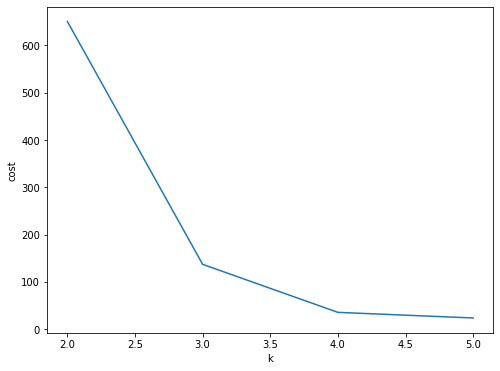

In [47]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,6),cost[2:6])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [48]:
# using standard scaler to transform the features 
scaler = StandardScaler(inputCol="a_failure_rate", outputCol="transformedFeatures", withStd=True)
scalerModel = scaler.fit(data)
cluster_data = scalerModel.transform(data)

In [49]:
# lets pass the transformed data to the kmeans package
#looking at the cost graph it feels like 3 would be a good option for number of clusters
kmeans = KMeans(featuresCol='transformedFeatures',k=3)
model = kmeans.fit(cluster_data)


In [50]:
# now getting the cluster centers
centers = model.clusterCenters()
centers = [center.tolist() for center in centers]
print(centers)

[[0.06354493841534699], [4.523329307999577], [0.545879114381973]]


In [51]:
cluster_data.show(5)

+-------------------+--------------------+--------------------+
|              model|      a_failure_rate| transformedFeatures|
+-------------------+--------------------+--------------------+
|        ST4000DM000|[1.9631260633468628]|[0.06641653091085...|
|      ST12000NM0007|[2.2233314514160156]|[0.07521980621881...|
|TOSHIBA MQ01ABF050M|[3.3564248085021973]|[0.1135546494980613]|
|       ST8000NM0055|[1.6354423761367798]|[0.05533032806993...|
|TOSHIBA MG07ACA14TA|[0.33362582325935...|[0.01128723733889...|
+-------------------+--------------------+--------------------+
only showing top 5 rows



In [53]:
predictions = model.transform(cluster_data).orderBy("prediction")

In [54]:
predictions.show(5)

+-------------------+--------------------+--------------------+----------+
|              model|      a_failure_rate| transformedFeatures|prediction|
+-------------------+--------------------+--------------------+----------+
|TOSHIBA MQ01ABF050M|[3.3564248085021973]|[0.1135546494980613]|         0|
|       ST8000NM0055|[1.6354423761367798]|[0.05533032806993...|         0|
|      ST12000NM0007|[2.2233314514160156]|[0.07521980621881...|         0|
|        ST4000DM000|[1.9631260633468628]|[0.06641653091085...|         0|
|TOSHIBA MG07ACA14TA|[0.33362582325935...|[0.01128723733889...|         0|
+-------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [55]:
# defining a user defined function to calculate the euclidean distance
euclidean = func.udf(lambda x,y: float(distance.euclidean(x, centers[y])), FloatType())

In [56]:
# calling the euclidean distance function on the tranformed features and storing it in distance column

predictions = predictions.withColumn('distance', euclidean(func.col('transformedFeatures'),func.col('prediction')))


In [57]:
predictions.show(5)

+-------------------+--------------------+--------------------+----------+------------+
|              model|      a_failure_rate| transformedFeatures|prediction|    distance|
+-------------------+--------------------+--------------------+----------+------------+
|        ST4000DM000|[1.9631260633468628]|[0.06641653091085...|         0|0.0028715925|
|      ST12000NM0007|[2.2233314514160156]|[0.07521980621881...|         0| 0.011674868|
|TOSHIBA MQ01ABF050M|[3.3564248085021973]|[0.1135546494980613]|         0| 0.050009713|
|       ST8000NM0055|[1.6354423761367798]|[0.05533032806993...|         0| 0.008214611|
|TOSHIBA MG07ACA14TA|[0.33362582325935...|[0.01128723733889...|         0|   0.0522577|
+-------------------+--------------------+--------------------+----------+------------+
only showing top 5 rows



In [58]:
# lets display the rows based on sorted distance in descending order
predictions = predictions.orderBy("prediction").orderBy(func.desc("distance"))

In [59]:
predictions.show(5)

+--------------------+--------------------+--------------------+----------+-----------+
|               model|      a_failure_rate| transformedFeatures|prediction|   distance|
+--------------------+--------------------+--------------------+----------+-----------+
|       ST500LM012 HN| [8.652877807617188]|[0.29274438208910...|         0| 0.22919944|
|          ST500LM030|[22.688030242919922]|[0.7675820162900872]|         2|  0.2217029|
|  TOSHIBA MQ01ABF050|  [10.8795166015625]|[0.36807608240450...|         2| 0.17780302|
|HGST HMS5C4040ALE640|[0.23294180631637...|[0.00788089311659...|         0|0.055664044|
|         ST6000DX000|[0.2687143087387085]|[0.00909114932848...|         0| 0.05445379|
+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [60]:
window = Window.partitionBy(predictions['prediction']).orderBy(predictions['distance'].desc())

In [61]:
# trying out different thresholds
threshold = 15

In [63]:
predictions.select('a_failure_rate','prediction','distance','model', rank().over(window).alias('rank')) .filter(func.col('rank') <= threshold) .show(10)



+--------------------+----------+-----------+--------------------+----+
|      a_failure_rate|prediction|   distance|               model|rank|
+--------------------+----------+-----------+--------------------+----+
| [133.6996307373047]|         1|        0.0|         ST8000DM004|   1|
|[22.688030242919922]|         2|  0.2217029|          ST500LM030|   1|
|  [10.8795166015625]|         2| 0.17780302|  TOSHIBA MQ01ABF050|   2|
|[14.837398529052734]|         2| 0.04389987|      WDC WD5000LPCX|   3|
| [8.652877807617188]|         0| 0.22919944|       ST500LM012 HN|   1|
|[0.23294180631637...|         0|0.055664044|HGST HMS5C4040ALE640|   2|
|[0.2687143087387085]|         0| 0.05445379|         ST6000DX000|   3|
|[0.33362582325935...|         0|  0.0522577| TOSHIBA MG07ACA14TA|   4|
|[0.34233611822128...|         0|0.051963013|HGST HMS5C4040BLE640|   5|
|[3.3564248085021973]|         0|0.050009713| TOSHIBA MQ01ABF050M|   6|
+--------------------+----------+-----------+-------------------

In [65]:
threshold_new = 10

In [66]:
predictions.select('a_failure_rate','prediction','distance','model', rank().over(window).alias('rank')) .filter(func.col('rank') <= threshold_new) .show(10)


+--------------------+----------+-----------+--------------------+----+
|      a_failure_rate|prediction|   distance|               model|rank|
+--------------------+----------+-----------+--------------------+----+
| [133.6996307373047]|         1|        0.0|         ST8000DM004|   1|
|[22.688030242919922]|         2|  0.2217029|          ST500LM030|   1|
|  [10.8795166015625]|         2| 0.17780302|  TOSHIBA MQ01ABF050|   2|
|[14.837398529052734]|         2| 0.04389987|      WDC WD5000LPCX|   3|
| [8.652877807617188]|         0| 0.22919944|       ST500LM012 HN|   1|
|[0.23294180631637...|         0|0.055664044|HGST HMS5C4040ALE640|   2|
|[0.2687143087387085]|         0| 0.05445379|         ST6000DX000|   3|
|[0.33362582325935...|         0|  0.0522577| TOSHIBA MG07ACA14TA|   4|
|[0.34233611822128...|         0|0.051963013|HGST HMS5C4040BLE640|   5|
|[3.3564248085021973]|         0|0.050009713| TOSHIBA MQ01ABF050M|   6|
+--------------------+----------+-----------+-------------------